<div align="right"><i>Peter Norvig, 23 Oct, 2017</i></div>

# Bicycling: Speed versus Grade, Eddington Number, and H-index

Like most people, I bike slower when I'm going up a steep hill than on a flat road. But how much slower?
To answer that, I downloaded all my recorded [Strava](https://www.strava.com/athletes/575579) rides longer than 25 miles as [`bikerides25.tsv`](bikerides25.tsv). Here I parse the file into a set of `Ride` structures:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import namedtuple

Ride = namedtuple('Ride', 'miles, feet, hours, date, title')

def parse_ride(line: str) -> Ride:
    """Parse a line from a Strava log file into a `Ride`. Line format is:
    Ride	Thu, 8/9/2018	BRNW	4:58:07	68.41 mi	3,862 ft"""
    _, date, title, time, mi, ft = line.strip().split('\t')
    return Ride(number(mi), number(ft), hours(time), date, title)

def number(string) -> float: return float(re.sub(r'[^0-9.]','', string))

def hours(time: str) -> float: 
    """Convert '1:30:00' to 1.5"""
    hour, min, sec = map(int, time.split(':'))
    return hour + min / 60 + sec / 3600

rides = map(parse_ride, open('bikerides25.tsv'))

A few of the rides were on stationary bikes and thus have 0 feet climbed; let's filter them out. A few others were mountain bike rides where I spent a lot of time off the bike pushing it uphill; I'll filter out rides < 8 mph:

In [2]:
rides = [r for r in rides if r.feet > 0 and r.miles / r.hours > 8]

Collect three vectors of numbers: miles per hour, feet climbed per mile, and miles per ride. Plot feet per mile versis miles per hour:

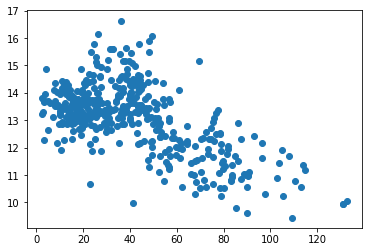

In [3]:
mph = [r.miles / r.hours for r in rides]
fpm = [r.feet / r.miles for r in rides]
mls = [r.miles for r in rides]

plt.scatter(fpm, mph);

As expected, there is a lot of variance, but overall speeds get slower as the grade gets steeper. Just eyeballing the scatter plot, it looks like a curve would be a better fit than a straight line, so I'll fit a quadratic (degree two) polynomial to the data, and make the plot prettier:

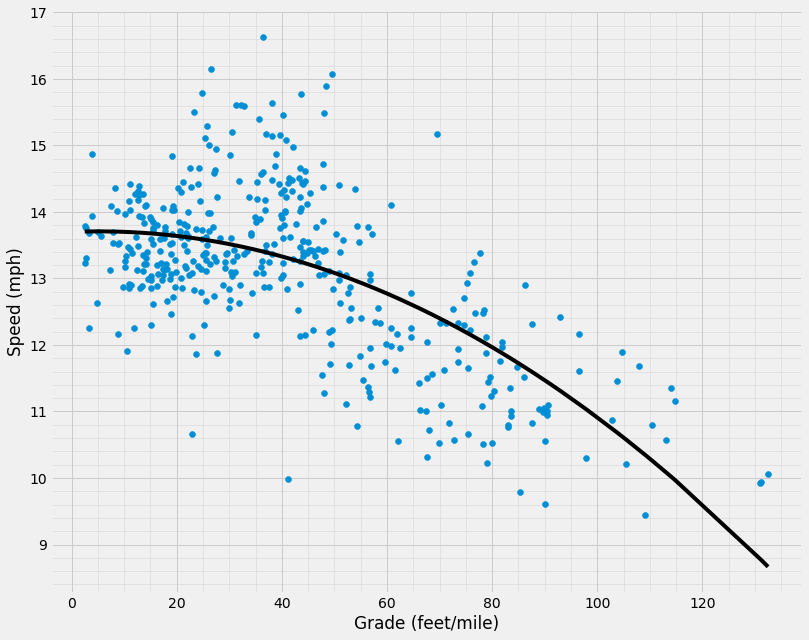

In [4]:
def show(X, Y, xlabel='Grade (feet/mile)', ylabel='Speed (mph)'): 
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.style.use('fivethirtyeight')
    plt.ylabel(ylabel); plt.xlabel(xlabel)
    plt.minorticks_on(); plt.grid(True, which='major'); plt.grid(True, which='minor', alpha=0.4)
    plt.scatter(X, Y)   
    X1 = sorted(set(X))
    F = quadratic_fit(X, Y)
    plt.plot(X1, [F(x) for x in X1], 'k-')
    
def quadratic_fit(X, Y):
    """The quadratic function that best fits the X,Y vectors."""
    a, b, c =  np.polyfit(X, Y, 2)
    return lambda x: a * x ** 2 + b * x + c

show(fpm, mph)     

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort than on the grade of the road. But from around 50 ft/mile grade speed falls off quickly: down to 12mph at 80 ft/mile; under 11 mph at 100 ft/mile; and under 9 mph at 130 ft/mile, Note that 130 ft/mile is only 2.5% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flatish, then that's 7.5% grade on the up part.

# Estimating Duration

For a route with a given distance and elevation, how long will it take to ride it?

In [5]:
def duration(dist, climb, F=quadratic_fit(fpm, mph)):
    "Given a distance in miles and total climb in feet, return estimated time in minutes."
    return 60 * dist / F(climb / dist)

For example, to get to  Pescadero from La Honda, I could take the flatter [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (15.7 miles, 344 ft climb), or the shorter [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (13.5 miles, 735 ft climb); which is faster?

In [6]:
duration(15.7, 344), duration(13.5, 735)

(69.15756109673171, 62.53280536304684)

This suggests the shorter creek route would be about 7 minutes faster. Good to know, but other factors (like the scenery) are probably more important in making the choice.

# Eddington Number

The physicist Sir Arthur Eddington was a pre-Strava bicyclist who favored this metric:

> *Your [Eddington Number](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the largest integer**&nbsp;E** for which you have bicycled**&nbsp;E** or more miles on**&nbsp;E** different days.*

Let's calculate mine, and see how many rides I need to take to improve it. For various number of miles, I'll list the number of rides of at least that long that I've taken, and the *gap*&mdash;the number of additional rides I would need to reach that Eddington number.

In [7]:
def eddington(distances, unit):
    """Print information on the number of rides and the Eddington gap."""
    print(f'{unit} Rides Gap')
    print(f'-- ----- ---')
    for E in range(1, 1000):
        num_rides = sum(d >= E for d in distances)
        gap = E - num_rides
        if -1 <= gap <= 45:
            print(f'{E:2}   {num_rides:2}   {gap:2}')

eddington(mls, 'Mi')

Mi Rides Gap
-- ----- ---
52   53   -1
53   51    2
54   48    6
55   46    9
56   45   11
57   42   15
58   39   19
59   34   25
60   33   27
61   27   34
62   25   37
63   23   40
64   21   43
65   20   45


So my **Eddington Number is 52**: I've done 53 rides of 52 miles or more, but not 53 rides of 53 miles. 

We can also calculate the metric Eddington number:

In [8]:
eddington([m * 1.60934 for m in mls], 'Km')

Km Rides Gap
-- ----- ---
75   75    0
76   74    2
77   73    4
78   71    7
79   70    9
80   69   11
81   66   15
82   58   24
83   57   26
84   52   32
85   51   34
86   50   36
87   48   39
88   47   41
89   46   43
90   45   45


My **metric Eddington Number is 75**, and I only need 11 rides of 80 km (50 miles) to get to 80.

# H-Index

Inspired by the [h-index](https://en.wikipedia.org/wiki/H-index) for scientific publications (and indirectly by Eddington's h-index-like metric), I invented a new h-index, or hill-index:

> *Your **h-index** is the largest integer **h** for which you can persistently and repeatedly climb an **h** percent grade at **h** miles per hour.*

My h-index is 6, because I can routinely climb a 6% grade at 6 miles per hour or more, but I only very rarely climb a 7% grade at 7 mph. What's yours?